In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Dense, Flatten, AvgPool2D, Dropout, Reshape
from tensorflow.keras import Model

In [ ]:
class Autoencoder(Model):
  def __init__(self):
    super(Autoencoder, self).__init__()
    #Defining the convolution layers
    self.c1 = Conv2D(32, 3, padding='same', activation='relu', data_format='channels_last', input_shape=(None,None,3))
    self.c2 = Conv2D(16, 3, padding='same',activation='relu')
    self.c3 = Conv2D(8, 3, padding='same',activation='relu')

    self.d1 = Dense(14*14*8, activation='relu')

    self.ct1 = Conv2DTranspose(64, 3, 2, padding='same',activation='relu')
    self.ct2 = Conv2DTranspose(32, 3, 2, padding='same', activation='relu')
    self.ct3 = Conv2DTranspose(1, 3, 1, padding='same', activation='sigmoid')

    self.flatten = Flatten()
    self.pool = AvgPool2D()
    self.dropout = Dropout(0.125)
    self.reshape = Reshape((14,14,8))
  def call(self, x):
    out = self.dropout(self.c2(self.pool(self.c1(x))))
    out = self.reshape(self.dropout(self.d1(self.flatten(out))))
    out = self.ct3(self.dropout(self.ct2(self.pool(self.ct1(out)))))
    return out

In [ ]:
model = Autoencoder()

In [ ]:
%pip install mnist

In [ ]:
import mnist

In [ ]:
import random
def distort_image(image):
    distorted_image = image[:,:,:]
    def add_spots_line():
        dim = min(image.shape[0], image.shape[1])
        num_distortions = random.randint(dim//6, dim//5)
        x = np.random.randint(image.shape[1] - 1, size=num_distortions)
        y = np.random.randint(image.shape[0] - 1, size=num_distortions)
        for j in x:
            for i in y:
                for k in range(distorted_image.shape[2]):
                    distorted_image[i][j][k] = random.random() * 255
    def add_blank_line():
        dim = min(image.shape[0], image.shape[1])
        num_distortions = random.randint(dim//6, dim//5)
        x = np.random.randint(image.shape[1] - 1, size=num_distortions)
        y = np.random.randint(image.shape[0] - 1, size=num_distortions)
        for j in x:
            for i in y:
                for k in range(distorted_image.shape[2]):
                    distorted_image[i][j][k] = 255
    def add_blank():
        dim = image.shape[0] * image.shape[1]
        num_distortions = random.randint(10, 25)
        for i in range(num_distortions):
            x = random.randint(0, image.shape[1] - 1)
            y = random.randint(0, image.shape[0] - 1)
            for j in range(image.shape[2]):
                distorted_image[y][x][j] = 255
    choice = random.random() * 3
    choices = {0:add_spots_line, 1: add_blank_line, 2: add_blank}
    choices[2]()
    return distorted_image


In [ ]:
images = mnist.train_images().astype(np.int32).reshape(-1,28,28,1)

In [ ]:
blurred_images = np.copy(images)
for i in range(images.shape[0]):
  blurred_images[i] = distort_image(images[i])

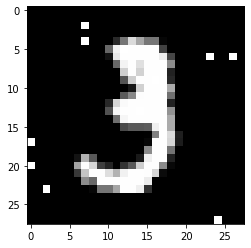

In [ ]:
plt.imshow(blurred_images[10][:,:,0], cmap='gray')

In [ ]:
loss_object = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(1e-3)

In [ ]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.BinaryAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.BinaryAccuracy(name='test_accuracy')

In [ ]:
@tf.function
def train_step(images, labels):
  with tf.GradientTape() as tape:
    predictions = model(images, training=True)
    loss = loss_object(255.0*labels, 255.0*predictions)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

  train_loss(loss)
  train_accuracy(labels, predictions)

In [ ]:
@tf.function
def test_step(images, labels):
  # training=False is only needed if there are layers with different
  # behavior during training versus inference (e.g. Dropout).
  predictions = model(images, training=False)
  t_loss = loss_object(255.0*labels, 255.0*predictions)

  test_loss(t_loss)
  test_accuracy(labels, predictions)

In [ ]:
blurred_images, images = blurred_images.astype(np.float32)/255.0, images.astype(np.float32)/255.0

In [ ]:
train_ds = tf.data.Dataset.from_tensor_slices(
    (images[:5000], images[:5000])).shuffle(1000).batch(100)

test_ds = tf.data.Dataset.from_tensor_slices((images[5000:6000], images[5000:6000])).batch(100)

In [ ]:
EPOCHS = 30
testLoss = []
x = []
for epoch in range(EPOCHS):
  x.append(epoch+1)
  train_loss.reset_states()
  train_accuracy.reset_states()
  test_loss.reset_states()
  test_accuracy.reset_states()

  for images, labels in train_ds:
    train_step(images, labels)

  for test_images, test_labels in test_ds:
    test_step(test_images, test_labels)
  testLoss.append(test_loss.result())
  print(
    f'Epoch {epoch + 1}, '
    f'Loss: {train_loss.result()}, '
    f'Accuracy: {train_accuracy.result() * 100}, '
    f'Test Loss: {test_loss.result()}, '
    f'Test Accuracy: {test_accuracy.result() * 100}'
  )

Epoch 1, Loss: 6820.75732421875, Accuracy: 79.05099487304688, Test Loss: 5312.23974609375, Test Accuracy: 78.33073425292969
Epoch 2, Loss: 4725.5048828125, Accuracy: 79.1266098022461, Test Loss: 4348.5576171875, Test Accuracy: 78.32461547851562
Epoch 3, Loss: 3995.38037109375, Accuracy: 78.8556900024414, Test Loss: 3813.178466796875, Test Accuracy: 77.76173400878906
Epoch 4, Loss: 3602.597900390625, Accuracy: 78.35263061523438, Test Loss: 3385.073486328125, Test Accuracy: 77.89949035644531
Epoch 5, Loss: 3177.875732421875, Accuracy: 78.40178680419922, Test Loss: 2738.12158203125, Test Accuracy: 77.87232208251953
Epoch 6, Loss: 2775.062744140625, Accuracy: 78.61148071289062, Test Loss: 2426.52099609375, Test Accuracy: 78.3414535522461
Epoch 7, Loss: 2552.615234375, Accuracy: 78.96456909179688, Test Loss: 2263.45849609375, Test Accuracy: 78.52181243896484
Epoch 8, Loss: 2432.514892578125, Accuracy: 79.0965347290039, Test Loss: 2153.454345703125, Test Accuracy: 78.6846923828125
Epoch 9, L

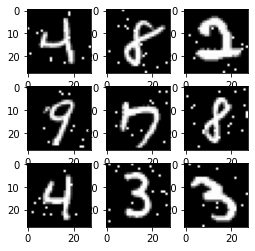

In [ ]:
image = model(blurred_images[8950:8959])
index = 8950
fig=plt.figure(figsize=(4, 4))
for i in range(9):
  fig.add_subplot(3,3,i+1)
  plt.imshow(blurred_images[8950+i][:,:,0],cmap='gray')


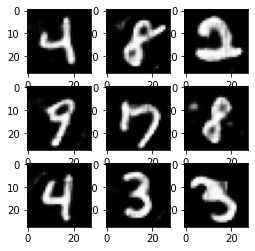

In [ ]:
fig=plt.figure(figsize=(4, 4))
for i in range(9):
  fig.add_subplot(3,3,i+1)
  plt.imshow(image[i][:,:,0],cmap='gray')

In [ ]:
testLoss[0].numpy()

5312.2397

In [ ]:
for i in range(len(testLoss)):
  testLoss[i] = testLoss[i].numpy()

Text(0.5, 1.0, 'Autoencoder Loss')

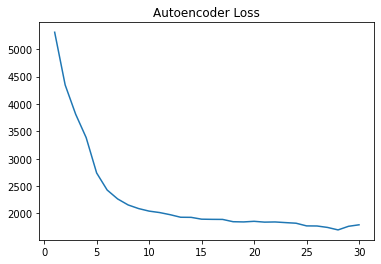

In [ ]:
plt.plot(x, testLoss)
plt.title('Autoencoder Loss')